In [1]:
import sys, os
import glob
import pickle
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.append('../src/')
from count_datasets import CountDataset, CountGridDataset
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from multimodal_datasets import MultiModalDataset, MultiModalGridDataset
from training import train_spotwise, train_gridwise

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Paths to count, image data
data_dir = '/Users/adaly/Desktop/BA44/'

meta = pd.read_csv(os.path.join(data_dir, 'Splotch_Metadata.tsv'), sep='\t', header=0)

count_files = np.array([os.path.join(data_dir, cfile) for cfile in meta['Count file']])
image_files = np.array([os.path.join(data_dir, ifile.replace('HE', 'HE_ccast')) for ifile in meta['Image file']])
annot_files = np.array([os.path.join(data_dir, afile.replace('annotations', 'annotations_splotch')).replace('csv', 'tsv') for afile in meta['Annotation file']])

count_files_pp = np.array([os.path.join(data_dir, 'countfiles_norm', Path(cf).name) for cf in count_files])

annot_names = pd.read_csv(annot_files[0], index_col=0, header=0, sep='\t').index

individuals = np.unique(meta['Level 3'])
partitions = [individuals[:3], individuals[3:6], individuals[6:9], individuals[9:]]

In [52]:
# Pre-process count data
from anndata import AnnData
from scanpy.pp import normalize_total, filter_cells, log1p

for infile, outfile in zip(count_files, count_files_pp):
    df = pd.read_csv(infile, sep='\t', header=0, index_col=0)
    genes = pd.DataFrame(index=df.index)
    spots = pd.DataFrame(index=df.columns)
    adat = AnnData(X=df.values.T, obs=spots, var=genes)
    
    filter_cells(adat, min_counts=100)                                    # Remove spots with <100 UMIs
    normalize_total(adat, target_sum=1e6, exclude_highly_expressed=True)  # CPM normalization
    log1p(adat)                                                           # log(x+1)-transform counts
    cmat = adat.X.T / np.log(1e6)                                         # Scale data between [0,1]
    
    df_pp = pd.DataFrame(cmat, index=adat.var.index, columns=adat.obs.index)
    df_pp.to_csv(outfile, sep='\t')

# 1. Registration using marker genes #

(78, 64, 14) (78, 64)
['Layer_1' 'Layer_2' 'Layer_3' 'Layer_4' 'Layer_5' 'Layer_6' 'Pia'
 'White_matter'] 0 8


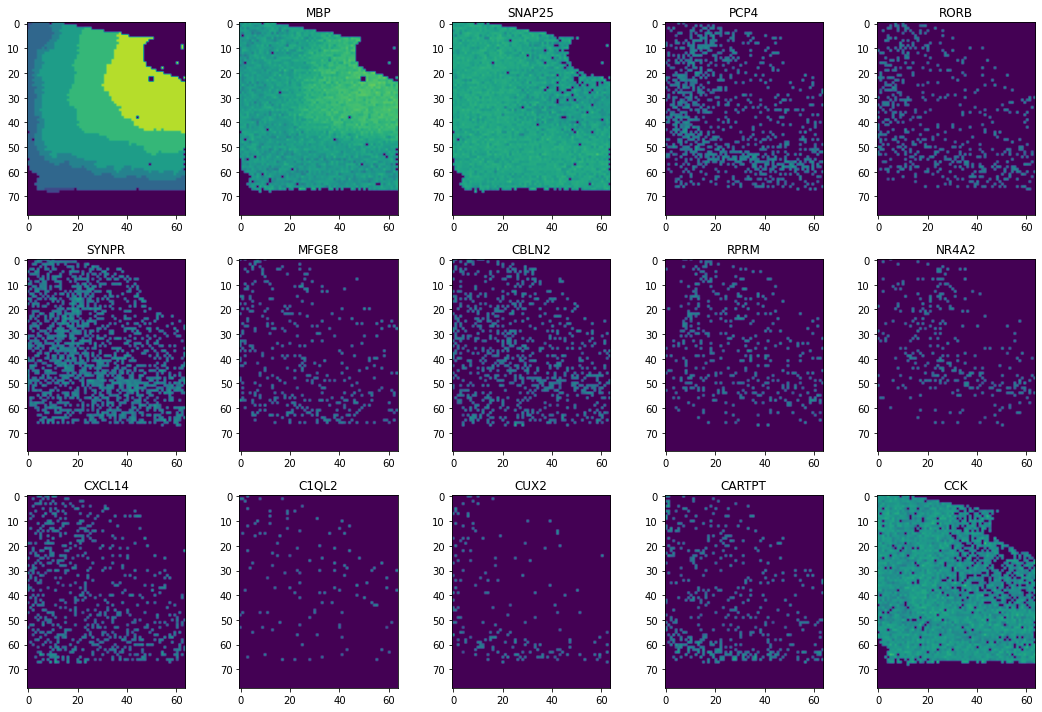

In [3]:
# Joana's manually curated list of layer marker genes:
jp_markers = {
    'MBP': 'ENSG00000197971.16',    # WM
    'SNAP25': 'ENSG00000132639.13', # GM (Layers 1-6)
    'PCP4': 'ENSG00000183036.11',   # Layer 5
    'RORB': 'ENSG00000198963.11',   # Layer 4
    'SYNPR': 'ENSG00000163630.11',  # Layer 6
    'MFGE8': 'ENSG00000140545.15',
    'CBLN2': 'ENSG00000141668.10',
    'RPRM': 'ENSG00000177519.4',
    'NR4A2': 'ENSG00000153234.15',
    'CXCL14': 'ENSG00000145824.13',
    'C1QL2': 'ENSG00000144119.4',
    'CUX2': 'ENSG00000111249.14',
    'CARTPT': 'ENSG00000164326.5',
    'CCK': 'ENSG00000187094.12'
}
select_genes = [ensmbl for _, ensmbl in jp_markers.items()]

counts_grid, annots_grid, gene_names, annot_names = read_annotated_starray(
    count_files_pp[4], annot_files[4], select_genes = [x for _,x in jp_markers.items()])
print(counts_grid.shape, annots_grid.shape)
print(annot_names, annots_grid.min(), annots_grid.max())

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(3,5,1)
ax.imshow(annots_grid, vmin=0, vmax=len(annot_names)+1)

for i, (cname, ensmbl) in enumerate(jp_markers.items()):
    ax = fig.add_subplot(3,5,i+2)
    ax.imshow(counts_grid[:,:,np.where(gene_names==ensmbl)[0][0]], vmin=0, vmax=1)
    ax.set_title(cname)
    
plt.tight_layout()
plt.show()

Test Partition: BA44_SD004/16, BA44_SD008/13, BA44_SD011/18
Epoch 0/99
----------
train Loss: 1.3109 Acc: 0.5323
val Loss: 0.9289 Acc: 0.6641

Epoch 1/99
----------
train Loss: 1.1032 Acc: 0.5718
val Loss: 0.9296 Acc: 0.6676

Epoch 2/99
----------
train Loss: 1.0716 Acc: 0.5774
val Loss: 0.9564 Acc: 0.6663

Epoch 3/99
----------
train Loss: 1.0600 Acc: 0.5799
val Loss: 0.9748 Acc: 0.6644

Epoch 4/99
----------
train Loss: 1.0531 Acc: 0.5804
val Loss: 0.9830 Acc: 0.6631

Epoch 5/99
----------
train Loss: 1.0492 Acc: 0.5824
val Loss: 0.9890 Acc: 0.6651

Epoch 6/99
----------
train Loss: 1.0454 Acc: 0.5834
val Loss: 0.9699 Acc: 0.6666

Epoch 7/99
----------
train Loss: 1.0427 Acc: 0.5848
val Loss: 1.0002 Acc: 0.6629

Epoch 8/99
----------
train Loss: 1.0412 Acc: 0.5850
val Loss: 0.9647 Acc: 0.6661

Epoch 9/99
----------
train Loss: 1.0397 Acc: 0.5854
val Loss: 0.9664 Acc: 0.6668

Epoch 10/99
----------
train Loss: 1.0371 Acc: 0.5867
val Loss: 0.9594 Acc: 0.6672

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 1.0111 Acc: 0.5950
val Loss: 0.9881 Acc: 0.6693

Epoch 98/99
----------
train Loss: 1.0104 Acc: 0.5951
val Loss: 1.0067 Acc: 0.6681

Epoch 99/99
----------
train Loss: 1.0108 Acc: 0.5958
val Loss: 0.9989 Acc: 0.6674

Training complete in 10m 34s
Best val Acc: 0.671609


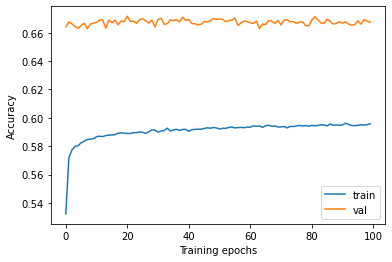

Test Partition: BA44_SD012/13, BA44_SD014/16, BA44_SD015/16
Epoch 0/99
----------
train Loss: 1.2699 Acc: 0.5714
val Loss: 1.3239 Acc: 0.4929

Epoch 1/99
----------
train Loss: 1.0149 Acc: 0.6219
val Loss: 1.2970 Acc: 0.4908

Epoch 2/99
----------
train Loss: 0.9820 Acc: 0.6282
val Loss: 1.3107 Acc: 0.4821

Epoch 3/99
----------
train Loss: 0.9695 Acc: 0.6305
val Loss: 1.3018 Acc: 0.4815

Epoch 4/99
----------
train Loss: 0.9610 Acc: 0.6325
val Loss: 1.3334 Acc: 0.4710

Epoch 5/99
----------
train Loss: 0.9558 Acc: 0.6346
val Loss: 1.3295 Acc: 0.4695

Epoch 6/99
----------
train Loss: 0.9520 Acc: 0.6347
val Loss: 1.3509 Acc: 0.4669

Epoch 7/99
----------
train Loss: 0.9486 Acc: 0.6360
val Loss: 1.3420 Acc: 0.4690

Epoch 8/99
----------
train Loss: 0.9473 Acc: 0.6363
val Loss: 1.3020 Acc: 0.4785

Epoch 9/99
----------
train Loss: 0.9440 Acc: 0.6364
val Loss: 1.3354 Acc: 0.4688

Epoch 10/99
----------
train Loss: 0.9421 Acc: 0.6380
val Loss: 1.3049 Acc: 0.4758

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.9097 Acc: 0.6473
val Loss: 1.3446 Acc: 0.4700

Epoch 98/99
----------
train Loss: 0.9097 Acc: 0.6472
val Loss: 1.3514 Acc: 0.4650

Epoch 99/99
----------
train Loss: 0.9095 Acc: 0.6474
val Loss: 1.3114 Acc: 0.4769

Training complete in 10m 25s
Best val Acc: 0.492919


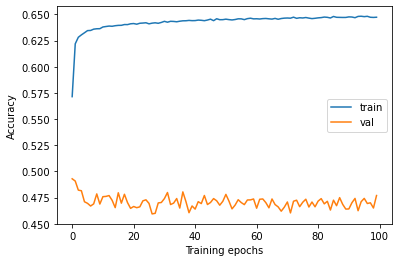

Test Partition: BA44_SD026/12, BA44_SD030/18, BA44_SD032/12
Epoch 0/99
----------
train Loss: 1.3345 Acc: 0.5332
val Loss: 1.0772 Acc: 0.6152

Epoch 1/99
----------
train Loss: 1.0910 Acc: 0.5818
val Loss: 0.9980 Acc: 0.6266

Epoch 2/99
----------
train Loss: 1.0653 Acc: 0.5859
val Loss: 0.9867 Acc: 0.6250

Epoch 3/99
----------
train Loss: 1.0544 Acc: 0.5875
val Loss: 0.9886 Acc: 0.6260

Epoch 4/99
----------
train Loss: 1.0490 Acc: 0.5905
val Loss: 0.9810 Acc: 0.6310

Epoch 5/99
----------
train Loss: 1.0435 Acc: 0.5914
val Loss: 0.9703 Acc: 0.6348

Epoch 6/99
----------
train Loss: 1.0396 Acc: 0.5926
val Loss: 0.9680 Acc: 0.6309

Epoch 7/99
----------
train Loss: 1.0379 Acc: 0.5934
val Loss: 0.9746 Acc: 0.6271

Epoch 8/99
----------
train Loss: 1.0353 Acc: 0.5936
val Loss: 0.9720 Acc: 0.6308

Epoch 9/99
----------
train Loss: 1.0332 Acc: 0.5939
val Loss: 0.9512 Acc: 0.6364

Epoch 10/99
----------
train Loss: 1.0314 Acc: 0.5950
val Loss: 0.9972 Acc: 0.6219

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 1.0035 Acc: 0.6041
val Loss: 0.9613 Acc: 0.6365

Epoch 98/99
----------
train Loss: 1.0032 Acc: 0.6050
val Loss: 0.9513 Acc: 0.6333

Epoch 99/99
----------
train Loss: 1.0030 Acc: 0.6052
val Loss: 0.9519 Acc: 0.6322

Training complete in 10m 29s
Best val Acc: 0.644369


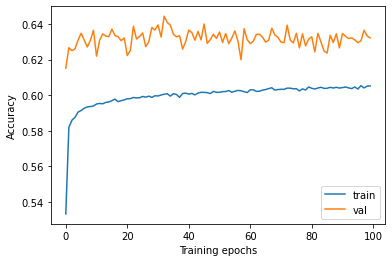

Test Partition: BA44_SD032/16, BA44_SD033/15, BA44_SD049/15
Epoch 0/99
----------
train Loss: 1.2860 Acc: 0.5580
val Loss: 1.2257 Acc: 0.5363

Epoch 1/99
----------
train Loss: 1.0405 Acc: 0.6075
val Loss: 1.1565 Acc: 0.5524

Epoch 2/99
----------
train Loss: 1.0129 Acc: 0.6118
val Loss: 1.1464 Acc: 0.5505

Epoch 3/99
----------
train Loss: 1.0016 Acc: 0.6150
val Loss: 1.1500 Acc: 0.5448

Epoch 4/99
----------
train Loss: 0.9958 Acc: 0.6163
val Loss: 1.1464 Acc: 0.5428

Epoch 5/99
----------
train Loss: 0.9906 Acc: 0.6174
val Loss: 1.1429 Acc: 0.5466

Epoch 6/99
----------
train Loss: 0.9890 Acc: 0.6179
val Loss: 1.1487 Acc: 0.5434

Epoch 7/99
----------
train Loss: 0.9862 Acc: 0.6183
val Loss: 1.1287 Acc: 0.5504

Epoch 8/99
----------
train Loss: 0.9828 Acc: 0.6199
val Loss: 1.1203 Acc: 0.5546

Epoch 9/99
----------
train Loss: 0.9819 Acc: 0.6200
val Loss: 1.1222 Acc: 0.5538

Epoch 10/99
----------
train Loss: 0.9807 Acc: 0.6206
val Loss: 1.1412 Acc: 0.5439

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.9535 Acc: 0.6302
val Loss: 1.1246 Acc: 0.5488

Epoch 98/99
----------
train Loss: 0.9530 Acc: 0.6295
val Loss: 1.1160 Acc: 0.5567

Epoch 99/99
----------
train Loss: 0.9528 Acc: 0.6295
val Loss: 1.1229 Acc: 0.5524

Training complete in 10m 37s
Best val Acc: 0.560857


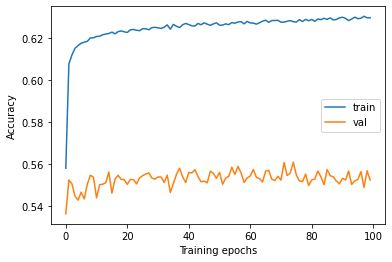

In [12]:
train_hist_part, val_hist_part = [],[]

for i, p in enumerate(partitions):
    print('Test Partition: %s' % ', '.join(p))
    val_inds = np.array([indiv in p for indiv in meta['Level 3']])
    train_inds = np.logical_not(val_inds)
    
    val_set = load_count_dataset(count_files_pp[val_inds], annot_files[val_inds], select_genes=select_genes)
    train_set = load_count_dataset(count_files_pp[train_inds], annot_files[train_inds], select_genes=select_genes)
    
    dataloader_spots = {
        'train': DataLoader(train_set, batch_size=128, shuffle=True),
        'val': DataLoader(val_set, batch_size=128)
    }
    
    spot_clf_markers = nn.Sequential(
        nn.Linear(len(select_genes), 50),
        nn.Linear(50, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),

        nn.Linear(100, 100),
        nn.Linear(100, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),

        nn.Linear(50, len(annot_names))
    )

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(spot_clf_markers.parameters(), lr=1e-4)

    spot_clf_markers, val_hist, train_hist = train_spotwise(spot_clf_markers, dataloader_spots, loss, optimizer, 100, display=False,
                                          outfile='../models/spot_classifier_markers_ba44_p%d.pth' % i)
    train_hist_part.append(train_hist)
    val_hist_part.append(val_hist)

    fig = plt.figure()
    plt.plot(train_hist, label='train')
    plt.plot(val_hist, label='val')
    plt.xlabel('Training epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

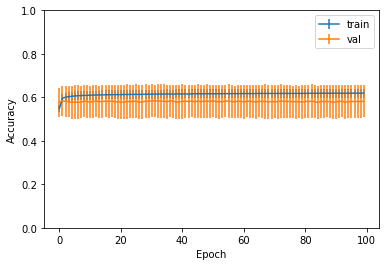

In [19]:
fig, ax = plt.subplots(1)

mva = np.array(val_hist_part).mean(axis=0)
mta = np.array(train_hist_part).mean(axis=0)
sva = np.array(val_hist_part).std(axis=0)
sta = np.array(train_hist_part).std(axis=0)

ax.errorbar(list(range(len(mta))), mta, yerr=sta, label='train')
ax.errorbar(list(range(len(mva))), mva, yerr=sva, label='val')

ax.set_ylim(0,1)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

# 2. Registration using count PCs #

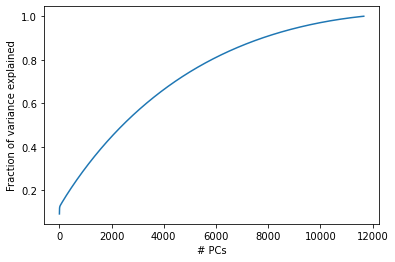

2424 PCs explain >50% of variance in normalized count data


In [4]:
# PCA should be fit to full count data using another script (BA44/counts_pca.py)
pca = pickle.load(open(os.path.join(data_dir, 'trained_pca.p'), 'rb'))

fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# PCs')
plt.ylabel('Fraction of variance explained')
plt.show()

npcs = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.5)[0][0] + 1
print('{} PCs explain >50% of variance in normalized count data'.format(npcs))

In [54]:
# Save PCs for each input array
count_files_pca = []

for cf in count_files_pp:
    count_dat = pd.read_csv(cf, header=0, index_col=0, sep='\t')
    X = pca.transform(count_dat.values.T)[:, :npcs]
    
    df = pd.DataFrame(X.T, columns=count_dat.columns, index=['PC%d' % i for i in range(npcs)])
    outfile = cf.replace('.unified.tsv', '.pca.tsv')
    count_files_pca.append(outfile)
    df.to_csv(outfile, sep='\t')

Test Partition: BA44_SD004/16, BA44_SD008/13, BA44_SD011/18
Epoch 0/99
----------
train Loss: 1.0061 Acc: 0.6627
val Loss: 0.6966 Acc: 0.7500

Epoch 1/99
----------
train Loss: 0.6895 Acc: 0.7379
val Loss: 0.6696 Acc: 0.7467

Epoch 2/99
----------
train Loss: 0.6086 Acc: 0.7636
val Loss: 0.6944 Acc: 0.7364

Epoch 3/99
----------
train Loss: 0.5326 Acc: 0.7954
val Loss: 0.7215 Acc: 0.7316

Epoch 4/99
----------
train Loss: 0.4467 Acc: 0.8337
val Loss: 0.7602 Acc: 0.7325

Epoch 5/99
----------
train Loss: 0.3636 Acc: 0.8692
val Loss: 0.8566 Acc: 0.7145

Epoch 6/99
----------
train Loss: 0.2949 Acc: 0.8969
val Loss: 0.9746 Acc: 0.7046

Epoch 7/99
----------
train Loss: 0.2386 Acc: 0.9191
val Loss: 1.0574 Acc: 0.6993

Epoch 8/99
----------
train Loss: 0.1961 Acc: 0.9347
val Loss: 1.1833 Acc: 0.6950

Epoch 9/99
----------
train Loss: 0.1631 Acc: 0.9469
val Loss: 1.2769 Acc: 0.6882

Epoch 10/99
----------
train Loss: 0.1367 Acc: 0.9556
val Loss: 1.3752 Acc: 0.6848

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.0142 Acc: 0.9950
val Loss: 3.0876 Acc: 0.6779

Epoch 98/99
----------
train Loss: 0.0146 Acc: 0.9950
val Loss: 3.1720 Acc: 0.6808

Epoch 99/99
----------
train Loss: 0.0129 Acc: 0.9958
val Loss: 3.1391 Acc: 0.6803

Training complete in 82m 53s
Best val Acc: 0.750000


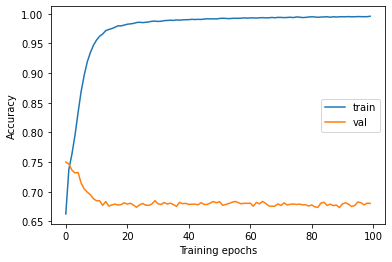

Test Partition: BA44_SD012/13, BA44_SD014/16, BA44_SD015/16
Epoch 0/99
----------
train Loss: 0.8757 Acc: 0.7153
val Loss: 1.3778 Acc: 0.5292

Epoch 1/99
----------
train Loss: 0.5904 Acc: 0.7774
val Loss: 1.4037 Acc: 0.5336

Epoch 2/99
----------
train Loss: 0.5226 Acc: 0.7986
val Loss: 1.4975 Acc: 0.5325

Epoch 3/99
----------
train Loss: 0.4509 Acc: 0.8291
val Loss: 1.5731 Acc: 0.5338

Epoch 4/99
----------
train Loss: 0.3705 Acc: 0.8628
val Loss: 1.7011 Acc: 0.5279

Epoch 5/99
----------
train Loss: 0.2913 Acc: 0.8971
val Loss: 1.8621 Acc: 0.5228

Epoch 6/99
----------
train Loss: 0.2280 Acc: 0.9227
val Loss: 2.1283 Acc: 0.5158

Epoch 7/99
----------
train Loss: 0.1771 Acc: 0.9421
val Loss: 2.2561 Acc: 0.5158

Epoch 8/99
----------
train Loss: 0.1427 Acc: 0.9546
val Loss: 2.3965 Acc: 0.5106

Epoch 9/99
----------
train Loss: 0.1153 Acc: 0.9640
val Loss: 2.6066 Acc: 0.5081

Epoch 10/99
----------
train Loss: 0.0937 Acc: 0.9717
val Loss: 2.8143 Acc: 0.5094

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.0097 Acc: 0.9968
val Loss: 5.9451 Acc: 0.5017

Epoch 98/99
----------
train Loss: 0.0109 Acc: 0.9963
val Loss: 5.9870 Acc: 0.5046

Epoch 99/99
----------
train Loss: 0.0111 Acc: 0.9962
val Loss: 6.0309 Acc: 0.5036

Training complete in 39m 33s
Best val Acc: 0.533843


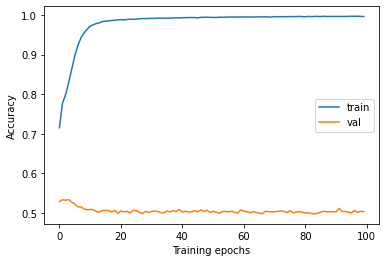

Test Partition: BA44_SD026/12, BA44_SD030/18, BA44_SD032/12
Epoch 0/99
----------
train Loss: 1.0046 Acc: 0.6663
val Loss: 0.7511 Acc: 0.7244

Epoch 1/99
----------
train Loss: 0.6794 Acc: 0.7432
val Loss: 0.7070 Acc: 0.7194

Epoch 2/99
----------
train Loss: 0.6016 Acc: 0.7670
val Loss: 0.7533 Acc: 0.7065

Epoch 3/99
----------
train Loss: 0.5320 Acc: 0.7949
val Loss: 0.7732 Acc: 0.7077

Epoch 4/99
----------
train Loss: 0.4535 Acc: 0.8287
val Loss: 0.8365 Acc: 0.6979

Epoch 5/99
----------
train Loss: 0.3776 Acc: 0.8620
val Loss: 0.8955 Acc: 0.6947

Epoch 6/99
----------
train Loss: 0.3092 Acc: 0.8911
val Loss: 1.0081 Acc: 0.6830

Epoch 7/99
----------
train Loss: 0.2538 Acc: 0.9127
val Loss: 1.1336 Acc: 0.6704

Epoch 8/99
----------
train Loss: 0.2146 Acc: 0.9268
val Loss: 1.1969 Acc: 0.6707

Epoch 9/99
----------
train Loss: 0.1731 Acc: 0.9438
val Loss: 1.3648 Acc: 0.6592

Epoch 10/99
----------
train Loss: 0.1464 Acc: 0.9530
val Loss: 1.3945 Acc: 0.6732

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.0138 Acc: 0.9955
val Loss: 3.1903 Acc: 0.6449

Epoch 98/99
----------
train Loss: 0.0176 Acc: 0.9941
val Loss: 3.1855 Acc: 0.6495

Epoch 99/99
----------
train Loss: 0.0214 Acc: 0.9930
val Loss: 3.1582 Acc: 0.6423

Training complete in 41m 32s
Best val Acc: 0.724389


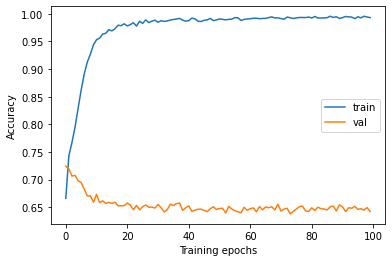

Test Partition: BA44_SD032/16, BA44_SD033/15, BA44_SD049/15
Epoch 0/99
----------
train Loss: 0.9607 Acc: 0.6863
val Loss: 0.8166 Acc: 0.6877

Epoch 1/99
----------
train Loss: 0.6571 Acc: 0.7522
val Loss: 0.7542 Acc: 0.7004

Epoch 2/99
----------
train Loss: 0.5784 Acc: 0.7771
val Loss: 0.7657 Acc: 0.6947

Epoch 3/99
----------
train Loss: 0.5045 Acc: 0.8075
val Loss: 0.7924 Acc: 0.6876

Epoch 4/99
----------
train Loss: 0.4242 Acc: 0.8429
val Loss: 0.8606 Acc: 0.6755

Epoch 5/99
----------
train Loss: 0.3438 Acc: 0.8759
val Loss: 0.9530 Acc: 0.6606

Epoch 6/99
----------
train Loss: 0.2777 Acc: 0.9034
val Loss: 1.0557 Acc: 0.6578

Epoch 7/99
----------
train Loss: 0.2238 Acc: 0.9242
val Loss: 1.1887 Acc: 0.6436

Epoch 8/99
----------
train Loss: 0.1827 Acc: 0.9399
val Loss: 1.3051 Acc: 0.6377

Epoch 9/99
----------
train Loss: 0.1508 Acc: 0.9511
val Loss: 1.4253 Acc: 0.6347

Epoch 10/99
----------
train Loss: 0.1259 Acc: 0.9599
val Loss: 1.5306 Acc: 0.6315

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.0126 Acc: 0.9955
val Loss: 3.5844 Acc: 0.6126

Epoch 98/99
----------
train Loss: 0.0119 Acc: 0.9958
val Loss: 3.5674 Acc: 0.6194

Epoch 99/99
----------
train Loss: 0.0116 Acc: 0.9959
val Loss: 3.6065 Acc: 0.6151

Training complete in 43m 17s
Best val Acc: 0.700415


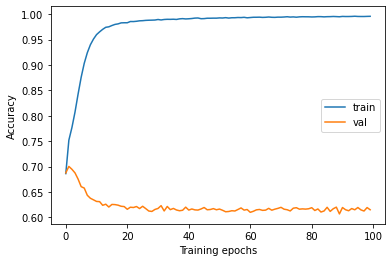

In [56]:
count_files_pca = np.array([cf.replace('.unified.tsv', '.pca.tsv') for cf in count_files_pp])

train_hist_part, val_hist_part = [],[]

for i, p in enumerate(partitions):
    print('Test Partition: %s' % ', '.join(p))
    val_inds = np.array([indiv in p for indiv in meta['Level 3']])
    train_inds = np.logical_not(val_inds)
    
    val_set = load_count_dataset(count_files_pca[val_inds], annot_files[val_inds])
    train_set = load_count_dataset(count_files_pca[train_inds], annot_files[train_inds])
    
    dataloader_spots = {
        'train': DataLoader(train_set, batch_size=128, shuffle=True),
        'val': DataLoader(val_set, batch_size=128)
    }
    
    spot_clf_pcs = nn.Sequential(
        nn.Linear(npcs, 500),
        nn.Linear(500, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),

        nn.Linear(100, 100),
        nn.Linear(100, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),

        nn.Linear(50, len(annot_names))
    )

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(spot_clf_pcs.parameters(), lr=1e-4)

    spot_clf_pcs, val_hist, train_hist = train_spotwise(spot_clf_pcs, dataloader_spots, loss, optimizer, 100, display=False,
                                          outfile='../models/spot_classifier_pcs_ba44_p%d.pth' % i)
    train_hist_part.append(train_hist)
    val_hist_part.append(val_hist)

    fig = plt.figure()
    plt.plot(train_hist, label='train')
    plt.plot(val_hist, label='val')
    plt.xlabel('Training epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

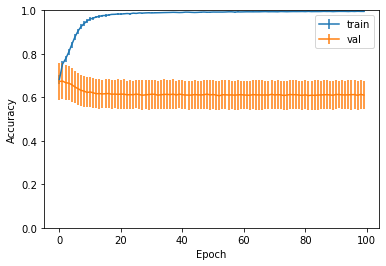

In [57]:
fig, ax = plt.subplots(1)

mva = np.array(val_hist_part).mean(axis=0)
mta = np.array(train_hist_part).mean(axis=0)
sva = np.array(val_hist_part).std(axis=0)
sta = np.array(train_hist_part).std(axis=0)

ax.errorbar(list(range(len(mta))), mta, yerr=sta, label='train')
ax.errorbar(list(range(len(mva))), mva, yerr=sva, label='val')

ax.set_ylim(0,1)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Registration using PCs w/GridNet #

Test Partition: BA44_SD004/16, BA44_SD008/13, BA44_SD011/18
Epoch 0/99
----------
train Loss: 4.4492 Acc: 0.6436
val Loss: 2.1416 Acc: 0.7412

Epoch 1/99
----------
train Loss: 1.4954 Acc: 0.7154
val Loss: 1.3531 Acc: 0.7213

Epoch 2/99
----------
train Loss: 1.0581 Acc: 0.7103
val Loss: 1.0333 Acc: 0.7396

Epoch 3/99
----------
train Loss: 0.8747 Acc: 0.7355
val Loss: 0.9887 Acc: 0.7298

Epoch 4/99
----------
train Loss: 0.7780 Acc: 0.7411
val Loss: 0.8663 Acc: 0.7541

Epoch 5/99
----------
train Loss: 0.7349 Acc: 0.7553
val Loss: 0.7992 Acc: 0.7553

Epoch 6/99
----------
train Loss: 0.6717 Acc: 0.7661
val Loss: 0.7871 Acc: 0.7528

Epoch 7/99
----------
train Loss: 0.6369 Acc: 0.7717
val Loss: 0.7305 Acc: 0.7594

Epoch 8/99
----------
train Loss: 0.6304 Acc: 0.7672
val Loss: 0.6955 Acc: 0.7689

Epoch 9/99
----------
train Loss: 0.6011 Acc: 0.7762
val Loss: 0.7000 Acc: 0.7675

Epoch 10/99
----------
train Loss: 0.5789 Acc: 0.7821
val Loss: 0.7114 Acc: 0.7687

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.4185 Acc: 0.8270
val Loss: 0.5801 Acc: 0.8085

Epoch 98/99
----------
train Loss: 0.4080 Acc: 0.8306
val Loss: 0.6180 Acc: 0.7952

Epoch 99/99
----------
train Loss: 0.4081 Acc: 0.8314
val Loss: 0.5803 Acc: 0.7956

Training complete in 7m 15s
Best val Acc: 0.814527


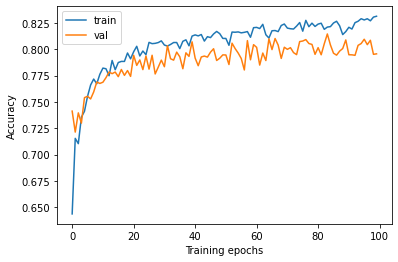

Test Partition: BA44_SD012/13, BA44_SD014/16, BA44_SD015/16
Epoch 0/99
----------
train Loss: 8.8836 Acc: 0.6796
val Loss: 17.0998 Acc: 0.5292

Epoch 1/99
----------
train Loss: 2.2436 Acc: 0.8291
val Loss: 11.8003 Acc: 0.5297

Epoch 2/99
----------
train Loss: 1.6439 Acc: 0.8354
val Loss: 11.0357 Acc: 0.5360

Epoch 3/99
----------
train Loss: 1.2384 Acc: 0.8491
val Loss: 8.3558 Acc: 0.5324

Epoch 4/99
----------
train Loss: 0.9753 Acc: 0.8494
val Loss: 7.7282 Acc: 0.5292

Epoch 5/99
----------
train Loss: 0.8309 Acc: 0.8565
val Loss: 5.8755 Acc: 0.5216

Epoch 6/99
----------
train Loss: 0.6777 Acc: 0.8601
val Loss: 5.2710 Acc: 0.5324

Epoch 7/99
----------
train Loss: 0.6074 Acc: 0.8594
val Loss: 5.1197 Acc: 0.5384

Epoch 8/99
----------
train Loss: 0.5425 Acc: 0.8653
val Loss: 4.3425 Acc: 0.5344

Epoch 9/99
----------
train Loss: 0.4962 Acc: 0.8684
val Loss: 4.2185 Acc: 0.5429

Epoch 10/99
----------
train Loss: 0.4730 Acc: 0.8709
val Loss: 3.9770 Acc: 0.5450

Epoch 11/99
----------



Epoch 97/99
----------
train Loss: 0.1560 Acc: 0.9395
val Loss: 2.4959 Acc: 0.5820

Epoch 98/99
----------
train Loss: 0.1600 Acc: 0.9379
val Loss: 2.1398 Acc: 0.5809

Epoch 99/99
----------
train Loss: 0.1616 Acc: 0.9379
val Loss: 2.2979 Acc: 0.5799

Training complete in 324m 0s
Best val Acc: 0.581975


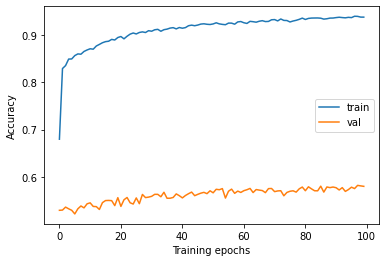

Test Partition: BA44_SD026/12, BA44_SD030/18, BA44_SD032/12
Epoch 0/99
----------
train Loss: 6.4051 Acc: 0.6041
val Loss: 2.2196 Acc: 0.6688

Epoch 1/99
----------
train Loss: 1.4810 Acc: 0.6921
val Loss: 1.5971 Acc: 0.6743

Epoch 2/99
----------
train Loss: 1.1167 Acc: 0.7111
val Loss: 1.1867 Acc: 0.6955

Epoch 3/99
----------
train Loss: 0.9480 Acc: 0.7258
val Loss: 1.0436 Acc: 0.7186

Epoch 4/99
----------
train Loss: 0.8262 Acc: 0.7371
val Loss: 1.0018 Acc: 0.7282

Epoch 5/99
----------
train Loss: 0.7601 Acc: 0.7528
val Loss: 0.9053 Acc: 0.7307

Epoch 6/99
----------
train Loss: 0.7030 Acc: 0.7618
val Loss: 0.9351 Acc: 0.7478

Epoch 7/99
----------
train Loss: 0.6749 Acc: 0.7704
val Loss: 0.7931 Acc: 0.7467

Epoch 8/99
----------
train Loss: 0.6506 Acc: 0.7697
val Loss: 0.7942 Acc: 0.7404

Epoch 9/99
----------
train Loss: 0.6234 Acc: 0.7729
val Loss: 0.7763 Acc: 0.7428

Epoch 10/99
----------
train Loss: 0.5931 Acc: 0.7804
val Loss: 0.8317 Acc: 0.7372

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.4090 Acc: 0.8302
val Loss: 0.6576 Acc: 0.7510

Epoch 98/99
----------
train Loss: 0.4188 Acc: 0.8262
val Loss: 0.5804 Acc: 0.7829

Epoch 99/99
----------
train Loss: 0.4003 Acc: 0.8349
val Loss: 0.6009 Acc: 0.7804

Training complete in 401m 32s
Best val Acc: 0.789295


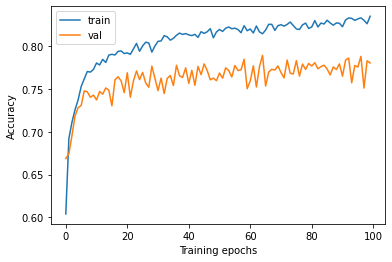

Test Partition: BA44_SD032/16, BA44_SD033/15, BA44_SD049/15
Epoch 0/99
----------
train Loss: 6.7648 Acc: 0.6046
val Loss: 2.7107 Acc: 0.6522

Epoch 1/99
----------
train Loss: 1.5592 Acc: 0.7280
val Loss: 1.7689 Acc: 0.6367

Epoch 2/99
----------
train Loss: 1.1975 Acc: 0.7130
val Loss: 1.4473 Acc: 0.6286

Epoch 3/99
----------
train Loss: 0.9637 Acc: 0.7363
val Loss: 1.4087 Acc: 0.6341

Epoch 4/99
----------
train Loss: 0.8857 Acc: 0.7430
val Loss: 1.2018 Acc: 0.6524

Epoch 5/99
----------
train Loss: 0.7789 Acc: 0.7543
val Loss: 1.2558 Acc: 0.6708

Epoch 6/99
----------
train Loss: 0.7425 Acc: 0.7629
val Loss: 1.0701 Acc: 0.6849

Epoch 7/99
----------
train Loss: 0.7219 Acc: 0.7617
val Loss: 1.0553 Acc: 0.6782

Epoch 8/99
----------
train Loss: 0.6630 Acc: 0.7768
val Loss: 1.0816 Acc: 0.6764

Epoch 9/99
----------
train Loss: 0.6641 Acc: 0.7711
val Loss: 1.0751 Acc: 0.6691

Epoch 10/99
----------
train Loss: 0.6352 Acc: 0.7764
val Loss: 0.9241 Acc: 0.7025

Epoch 11/99
----------
tra


Epoch 97/99
----------
train Loss: 0.3462 Acc: 0.8602
val Loss: 0.6916 Acc: 0.7483

Epoch 98/99
----------
train Loss: 0.3318 Acc: 0.8640
val Loss: 0.6653 Acc: 0.7493

Epoch 99/99
----------
train Loss: 0.3340 Acc: 0.8640
val Loss: 0.7049 Acc: 0.7521

Training complete in 34m 5s
Best val Acc: 0.756419


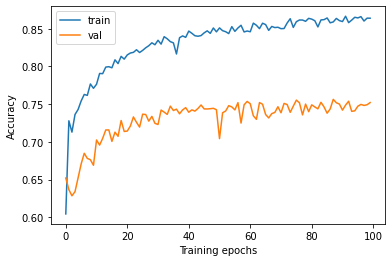

In [6]:
from gridnet_models import GridNetHexOddr

H_VISIUM = 78
W_VISIUM = 64

spot_clf_pcs = nn.Sequential(
    nn.Linear(npcs, 500),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),

    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, len(annot_names))
)

train_hist_part, val_hist_part = [],[]
count_files_pca = np.array([cf.replace('.unified.tsv', '.pca.tsv') for cf in count_files_pp])

for i, p in enumerate(partitions):
    print('Test Partition: %s' % ', '.join(p))
    val_inds = np.array([indiv in p for indiv in meta['Level 3']])
    train_inds = np.logical_not(val_inds)
    
    train_grid_pca = load_count_grid_dataset(count_files_pca[train_inds], annot_files[train_inds])
    val_grid_pca = load_count_grid_dataset(count_files_pca[val_inds], annot_files[val_inds])
    
    dataloader_grid_pca = {
        'train': DataLoader(train_grid_pca, batch_size=1, shuffle=True),
        'val': DataLoader(val_grid_pca, batch_size=1, shuffle=False)
    }
    
    # Instantiate GridNetHex, then load pre-trained spot classifier by name
    gnet_pca = GridNetHexOddr(spot_clf_pcs, (npcs,), (H_VISIUM, W_VISIUM), n_classes=len(annot_names),
                 use_bn=False)
    classifier_pfile = '../models/spot_classifier_pcs_ba44_p%d.pth' % i
    gnet_pca.patch_classifier.load_state_dict(torch.load(classifier_pfile))

    # Fixing the parameters of the patch classifier allows slightly faster training, even when only
    #   optimizing the parameters of the corrector. 
    for param in gnet_pca.patch_classifier.parameters():
        param.requires_grad = False

    loss = nn.CrossEntropyLoss()

    # Only optimize the parameters in the g-network
    optimizer = torch.optim.Adam(gnet_pca.corrector.parameters(), lr=1e-3)

    gnet_pca, val_hist, train_hist = train_gridwise(gnet_pca, dataloader_grid_pca, loss, optimizer, num_epochs=100,
                                      outfile='../models/gnet_pca_p%d.pth' % i)
    train_hist_part.append(train_hist)
    val_hist_part.append(val_hist)

    fig = plt.figure()
    plt.plot(train_hist, label='train')
    plt.plot(val_hist, label='val')
    plt.xlabel('Training epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

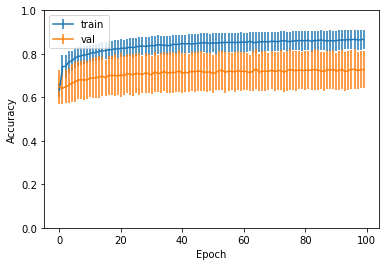

In [7]:
fig, ax = plt.subplots(1)

mva = np.array(val_hist_part).mean(axis=0)
mta = np.array(train_hist_part).mean(axis=0)
sva = np.array(val_hist_part).std(axis=0)
sta = np.array(train_hist_part).std(axis=0)

ax.errorbar(list(range(len(mta))), mta, yerr=sta, label='train')
ax.errorbar(list(range(len(mva))), mva, yerr=sva, label='val')

ax.set_ylim(0,1)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()